In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *

np.random.seed(123)

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [2]:
# define transform function to constrain parameter values
def transform(params):
    
    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = params
    
    # take exp of strictly positive parameters
    mu_max = jnp.exp2(mu_max) 
    pref = jnp.exp2(pref)*7.
    Sigma_inv = jnp.exp2(Sigma_inv)/10.
    K_inv = jnp.exp2(K_inv)/10.
    delta = jnp.exp2(delta)/10.
    gamma = gamma/10.
    
    return jnp.array([mu_max, pref, Sigma_inv, K_inv, delta, gamma])

# ode 
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = transform(params)
    
    # unpack variables
    od, pH = x 
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp2(-Sigma_inv * (pH - pref)**2.) - delta) 
    dpH = (gamma * od) * (pH * (2. - pH / 7.))
    # dpH = (gamma * dod) * (pH * (2. - pH / 7.))
    
    return jnp.array([dod, dpH])  

# define prior mean of untransformed variables 
prior_mean = np.array([0., 0., 0., 0., 0., 0.])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [3]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [4]:
df.describe()

,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,8.823529,6.284827,0.103395,0.024959,0.015209,0.018839,0.027583,0.016583,0.021769,0.002393,0.090695,0.079882,0.083556,0.097024
std,7.938535,1.033571,0.653701,0.278782,0.150054,0.180187,0.222743,0.208608,0.201716,0.009162,0.530186,0.463441,0.473807,0.582427
min,0.000000,4.976477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.152622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.168138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,7.337288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,8.150575,5.147123,4.072533,2.927829,2.700796,3.934214,3.976187,3.789218,0.075608,4.856178,4.326752,4.344400,5.313583


In [5]:
all_species = df.columns.values[3:]
all_species

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD'],
      dtype=object)

In [16]:
sp = all_species[10][:-3]
sp

'parc-'

In [17]:
df_species = pd.concat([df_exp[['Treatments', 'Time', 'pH', sp+'_OD']] 
                   for exp_name, df_exp in df.groupby("Treatments") if sp in exp_name])
df_species

,Treatments,Time,pH,parc-_OD
1044,parc-_pH4_0,0,5.018455,0.010000
1045,parc-_pH4_0,3,5.052249,0.010000
1046,parc-_pH4_0,6,5.041834,0.010000
1047,parc-_pH4_0,9,5.076731,0.010000
1048,parc-_pH4_0,24,5.058436,0.010000
...,...,...,...,...
1129,parc-_pH9_2,0,8.132268,0.010000
1130,parc-_pH9_2,3,7.985588,0.427127
1131,parc-_pH9_2,6,7.199284,2.297765
1132,parc-_pH9_2,9,6.645328,3.723875


## Specify system state variables 

In [18]:
# names of species
species = [sp+'_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [19]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_species, 
            sys_vars = species, 
            prior_mean = prior_mean)

## Fit the parameter posterior

In [20]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM()

print("Elapsed time {:.2f}s".format(time.time()-t0))

Updating posterior...
Epoch 1, NEG ELBO: 50251.995
Epoch 2, NEG ELBO: 10054.453
Epoch 3, NEG ELBO: 9207.563
Epoch 4, NEG ELBO: 13015.653
Epoch 5, NEG ELBO: 8565.472
Epoch 6, NEG ELBO: 6716.394
Epoch 7, NEG ELBO: 6617.361
Epoch 8, NEG ELBO: 8950.275
Epoch 9, NEG ELBO: 8837.023
Epoch 10, NEG ELBO: 5425.031
set lr to 1.000e-02
Epoch 11, NEG ELBO: 5193.575, Slope: -0.042
set lr to 1.000e-02
Epoch 12, NEG ELBO: 4725.803, Slope: -0.048
set lr to 1.000e-02
Epoch 13, NEG ELBO: 8481.570, Slope: -0.037
set lr to 1.000e-02
Epoch 14, NEG ELBO: 7611.473, Slope: -0.014
Epoch 15, NEG ELBO: 6436.414, Slope: -0.007
set lr to 1.000e-02
Epoch 16, NEG ELBO: 3858.536, Slope: -0.027
set lr to 1.000e-02
Epoch 17, NEG ELBO: 3614.281, Slope: -0.045
set lr to 1.000e-02
Epoch 18, NEG ELBO: 3879.532, Slope: -0.041
set lr to 1.000e-02
Epoch 19, NEG ELBO: 4499.556, Slope: -0.027
set lr to 1.000e-02
Epoch 20, NEG ELBO: 3479.884, Slope: -0.039
set lr to 1.000e-02
Epoch 21, NEG ELBO: 4501.632, Slope: -0.043
set lr to 

set lr to 5.475e-03
Epoch 146, NEG ELBO: 1784.038, Slope: -0.044
set lr to 6.023e-03
Epoch 147, NEG ELBO: 1973.299, Slope: -0.045
set lr to 6.625e-03
Epoch 148, NEG ELBO: 1808.515, Slope: -0.042
set lr to 7.288e-03
Epoch 149, NEG ELBO: 1897.287, Slope: -0.037
set lr to 8.016e-03
Epoch 150, NEG ELBO: 1898.368, Slope: -0.048
set lr to 8.818e-03
Epoch 151, NEG ELBO: 1917.539, Slope: -0.040
set lr to 9.700e-03
Epoch 152, NEG ELBO: 1842.206, Slope: -0.028
set lr to 1.000e-02
Epoch 153, NEG ELBO: 1797.297, Slope: -0.017
Epoch 154, NEG ELBO: 1943.448, Slope: -0.007
decrease lr to 9.000e-03
Epoch 155, NEG ELBO: 2035.448, Slope: 0.006
Epoch 156, NEG ELBO: 1801.333, Slope: -0.000
decrease lr to 8.100e-03
Epoch 157, NEG ELBO: 10885.200, Slope: 0.046
decrease lr to 7.290e-03
Epoch 158, NEG ELBO: 5646.424, Slope: 0.054
decrease lr to 6.561e-03
Epoch 159, NEG ELBO: 2943.632, Slope: 0.045
decrease lr to 5.905e-03
Epoch 160, NEG ELBO: 2197.075, Slope: 0.031
decrease lr to 5.314e-03
Epoch 161, NEG ELBO

set lr to 2.690e-03
Epoch 289, NEG ELBO: 1892.781, Slope: -0.028
set lr to 2.958e-03
Epoch 290, NEG ELBO: 1882.971, Slope: -0.027
set lr to 3.254e-03
Epoch 291, NEG ELBO: 2176.254, Slope: -0.013
set lr to 3.580e-03
Epoch 292, NEG ELBO: 2073.665, Slope: -0.010
Epoch 293, NEG ELBO: 2165.484, Slope: -0.008
set lr to 3.938e-03
Epoch 294, NEG ELBO: 1977.449, Slope: -0.010
Epoch 295, NEG ELBO: 2000.321, Slope: -0.009
Epoch 296, NEG ELBO: 2154.113, Slope: -0.001
decrease lr to 3.544e-03
Epoch 297, NEG ELBO: 2186.594, Slope: 0.010
decrease lr to 3.190e-03
Epoch 298, NEG ELBO: 2067.068, Slope: 0.009
decrease lr to 2.871e-03
Epoch 299, NEG ELBO: 1985.592, Slope: 0.002
decrease lr to 2.584e-03
Epoch 300, NEG ELBO: 6403.986, Slope: 0.036
decrease lr to 2.325e-03
Epoch 301, NEG ELBO: 5541.659, Slope: 0.058
decrease lr to 2.093e-03
Epoch 302, NEG ELBO: 4281.587, Slope: 0.062
decrease lr to 1.883e-03
Epoch 303, NEG ELBO: 5178.238, Slope: 0.070
decrease lr to 1.695e-03
Epoch 304, NEG ELBO: 4283.492, S

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 239.61it/s]


Updating posterior...
Epoch 1, NEG ELBO: 99.025
Epoch 2, NEG ELBO: 80.787
Epoch 3, NEG ELBO: 117.835
Epoch 4, NEG ELBO: 86.176
Epoch 5, NEG ELBO: 85.877
Epoch 6, NEG ELBO: 84.544
Epoch 7, NEG ELBO: 88.668
Epoch 8, NEG ELBO: 78.643
Epoch 9, NEG ELBO: 575.016
Epoch 10, NEG ELBO: 815.373
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 558.950, Slope: 0.086
decrease lr to 8.100e-03
Epoch 12, NEG ELBO: 538.132, Slope: 0.091
decrease lr to 7.290e-03
Epoch 13, NEG ELBO: 527.246, Slope: 0.091
decrease lr to 6.561e-03
Epoch 14, NEG ELBO: 457.203, Slope: 0.077
decrease lr to 5.905e-03
Epoch 15, NEG ELBO: 445.043, Slope: 0.057
decrease lr to 5.314e-03
Epoch 16, NEG ELBO: 427.652, Slope: 0.031
Epoch 17, NEG ELBO: 417.890, Slope: -0.001
set lr to 5.846e-03
Epoch 18, NEG ELBO: 391.927, Slope: -0.040
set lr to 6.430e-03
Epoch 19, NEG ELBO: 394.422, Slope: -0.044
set lr to 7.073e-03
Epoch 20, NEG ELBO: 403.673, Slope: -0.035
set lr to 7.781e-03
Epoch 21, NEG ELBO: 400.629, Slope: -0.029
set lr to 8.559e-

Epoch 164, NEG ELBO: 116.820, Slope: -0.007
set lr to 4.326e-03
Epoch 165, NEG ELBO: 110.701, Slope: -0.012
set lr to 4.758e-03
Epoch 166, NEG ELBO: 100.013, Slope: -0.022
set lr to 5.234e-03
Epoch 167, NEG ELBO: 102.278, Slope: -0.017
set lr to 5.757e-03
Epoch 168, NEG ELBO: 108.207, Slope: -0.015
set lr to 6.333e-03
Epoch 169, NEG ELBO: 97.574, Slope: -0.017
set lr to 6.966e-03
Epoch 170, NEG ELBO: 105.685, Slope: -0.025
set lr to 7.663e-03
Epoch 171, NEG ELBO: 106.064, Slope: -0.014
set lr to 8.429e-03
Epoch 172, NEG ELBO: 90.195, Slope: -0.016
Epoch 173, NEG ELBO: 109.032, Slope: -0.010
Epoch 174, NEG ELBO: 92.847, Slope: -0.009
Epoch 175, NEG ELBO: 94.874, Slope: -0.007
set lr to 9.272e-03
Epoch 176, NEG ELBO: 95.158, Slope: -0.010
Epoch 177, NEG ELBO: 103.258, Slope: -0.008
Epoch 178, NEG ELBO: 94.901, Slope: -0.005
Epoch 179, NEG ELBO: 102.342, Slope: -0.005
Epoch 180, NEG ELBO: 82.938, Slope: -0.009
decrease lr to 8.345e-03
Epoch 181, NEG ELBO: 106.714, Slope: 0.001
Epoch 182, 

100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 61.70it/s]


Log evidence: -220.187 +/- 0.000
Updating hyperparameters...


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 242.99it/s]


Updating posterior...
Epoch 1, NEG ELBO: 93.288
Epoch 2, NEG ELBO: 107.621
Epoch 3, NEG ELBO: 97.830
Epoch 4, NEG ELBO: 88.553
Epoch 5, NEG ELBO: 91.911
Epoch 6, NEG ELBO: 86.365
Epoch 7, NEG ELBO: 87.549
Epoch 8, NEG ELBO: 93.179
Epoch 9, NEG ELBO: 89.762
Epoch 10, NEG ELBO: 98.618
Epoch 11, NEG ELBO: 100.026, Slope: -0.003
decrease lr to 9.000e-03
Epoch 12, NEG ELBO: 430.253, Slope: 0.044
decrease lr to 8.100e-03
Epoch 13, NEG ELBO: 133.666, Slope: 0.040
decrease lr to 7.290e-03
Epoch 14, NEG ELBO: 133.677, Slope: 0.035
decrease lr to 6.561e-03
Epoch 15, NEG ELBO: 136.820, Slope: 0.028
decrease lr to 5.905e-03
Epoch 16, NEG ELBO: 131.464, Slope: 0.019
decrease lr to 5.314e-03
Epoch 17, NEG ELBO: 126.842, Slope: 0.008
Epoch 18, NEG ELBO: 117.528, Slope: -0.004
Epoch 19, NEG ELBO: 181.315, Slope: -0.009
set lr to 5.846e-03
Epoch 20, NEG ELBO: 138.973, Slope: -0.021
set lr to 6.430e-03
Epoch 21, NEG ELBO: 130.656, Slope: -0.035
decrease lr to 5.787e-03
Epoch 22, NEG ELBO: 131.856, Slope

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 63.19it/s]

Log evidence: -259.320 +/- 0.000
Elapsed time 51.67s


In [21]:
# ode_model.estimate_evidence()

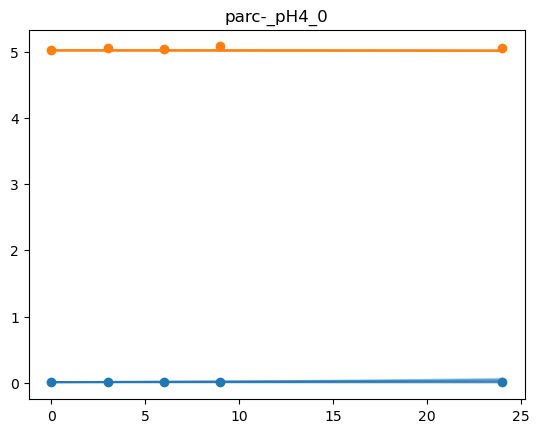

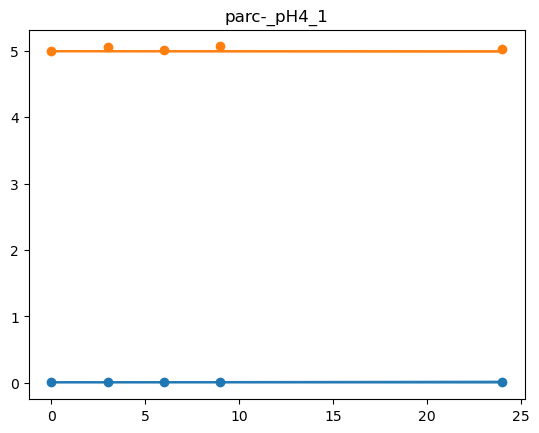

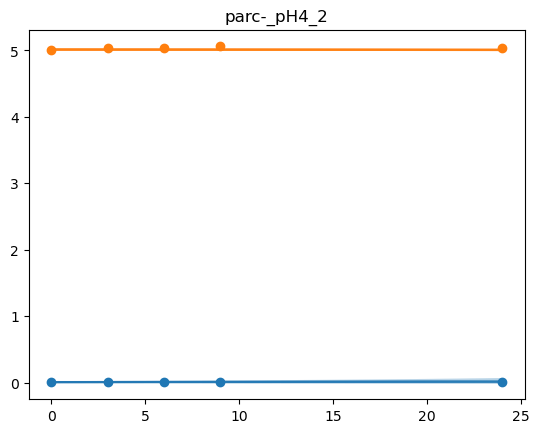

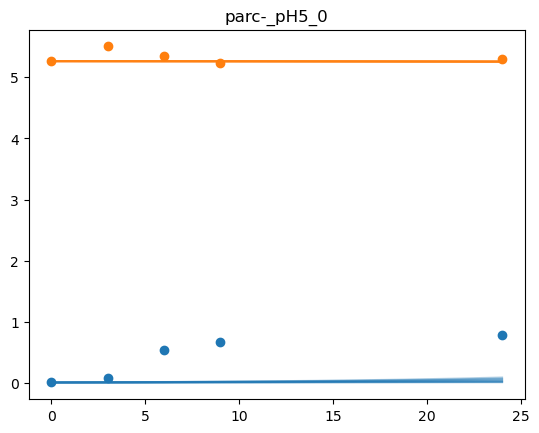

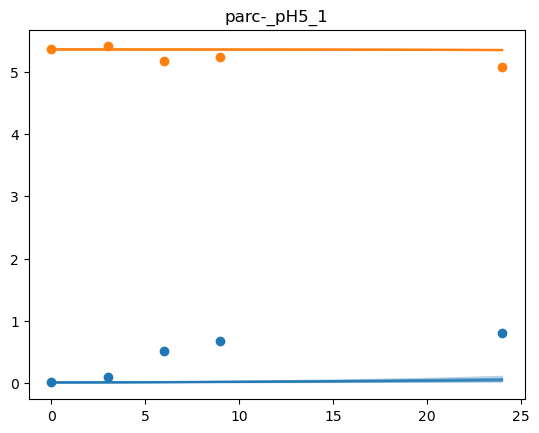

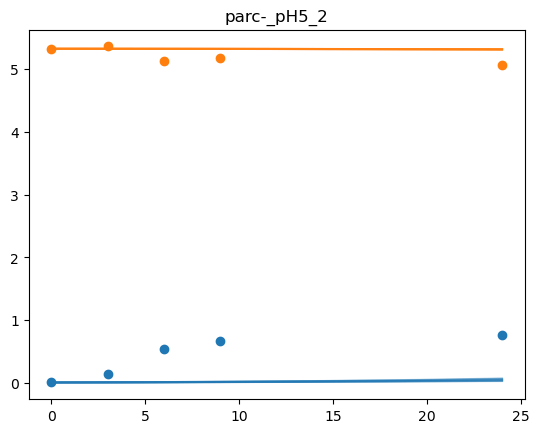

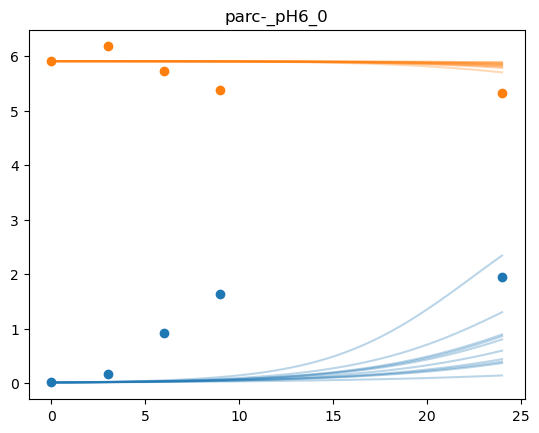

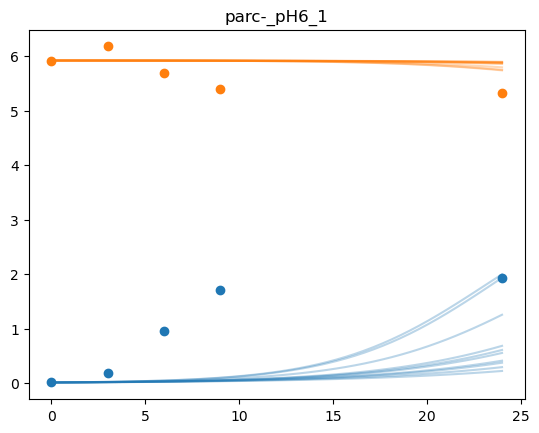

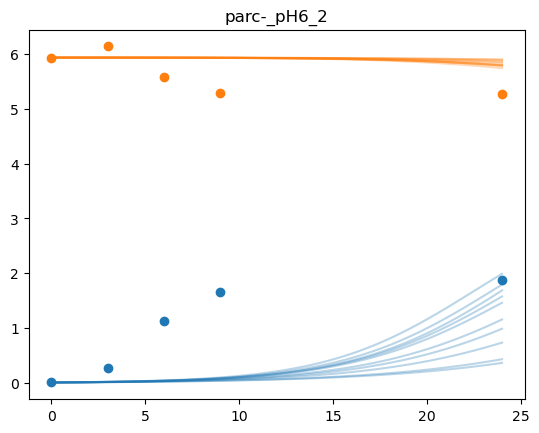

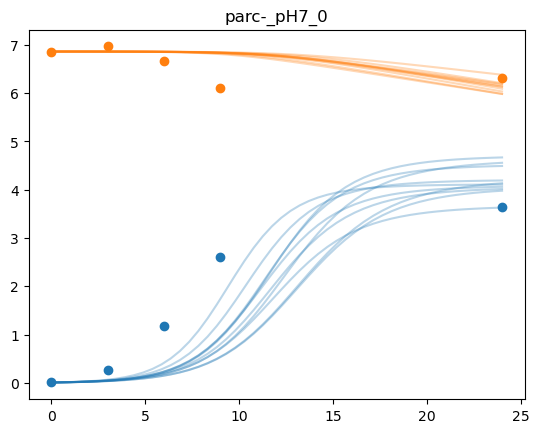

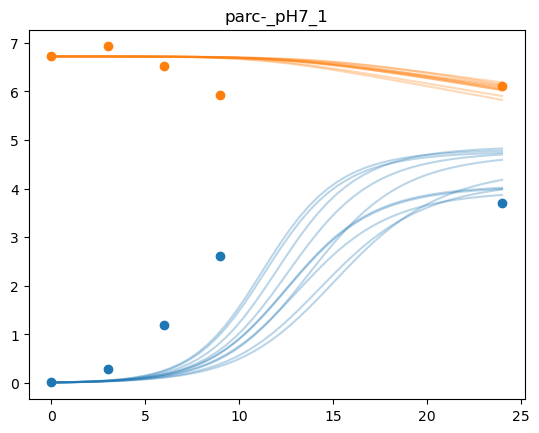

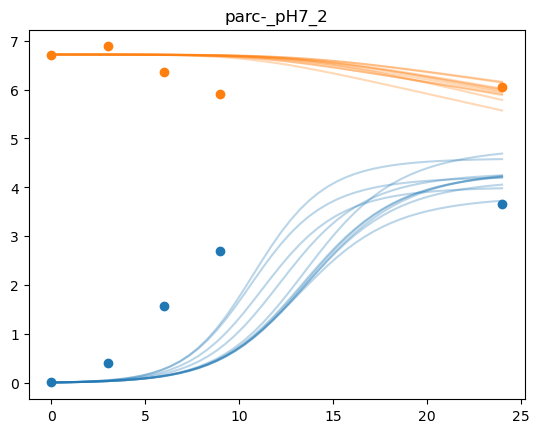

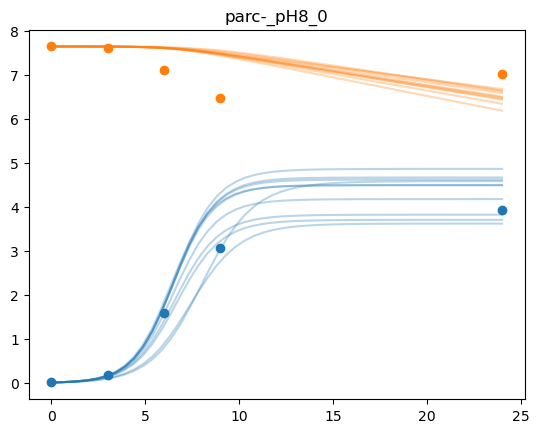

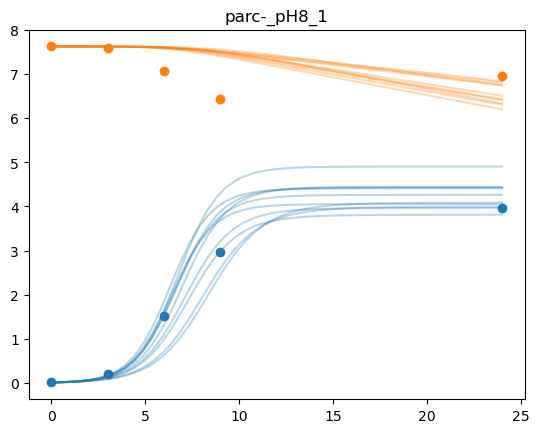

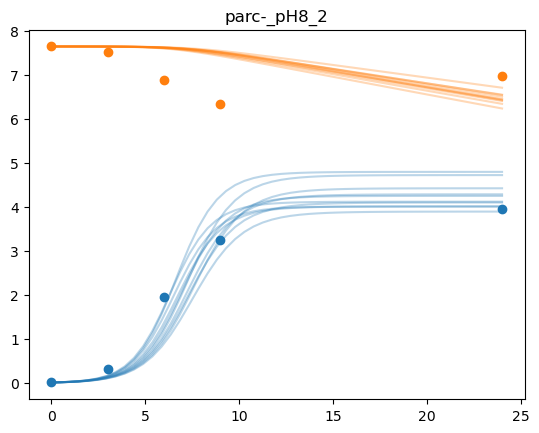

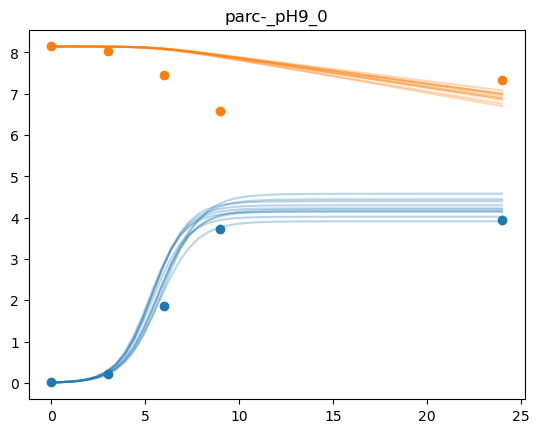

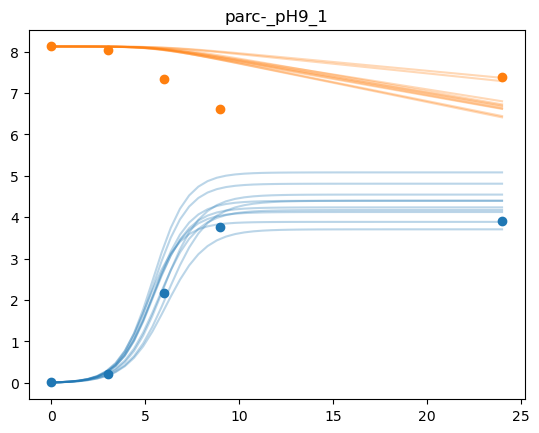

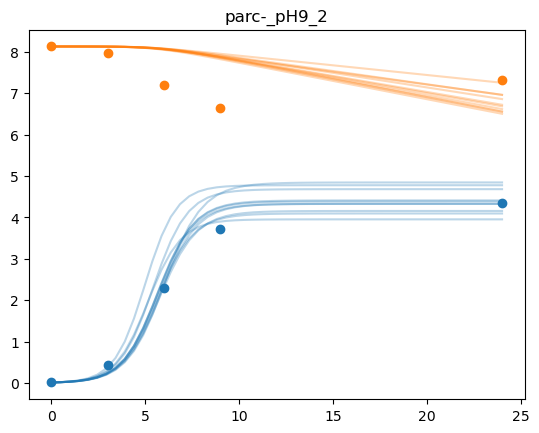

In [22]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_species.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    # y_preds = ode_model.predict_prior(x0, t_eval, n_sample=10)
    y_preds = ode_model.predict_sample(x0, t_eval, n_sample=10)
    
    # plot 
    for i, s in enumerate(species[:2]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

In [23]:
ode_model.estimate_evidence(n_sample=1000, n_trials=3)

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.15it/s]

Log evidence: -267.710 +/- 43.829


In [24]:
ode_model.param_df()

,mean,stdv
0,1.420132,0.047565
1,9.273672,0.090225
2,0.205024,0.008916
3,0.332815,0.021342
4,0.063866,0.012355
5,-0.002261,0.000354


In [25]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params.to_csv('Fitting/'+sp+'_param.csv')